# Modeling Ski Season Length for Lake Tahoe Resorts

## Introduction

This notebook (Part 2 of 2) focuses on developing and evaluating machine learning models to predict ski season length based on weather patterns and climate indicators. Building on the data processing and exploratory analysis from Notebook 1, we will:

1. Prepare our processed data for modeling
2. Develop and compare multiple regression models
3. Evaluate model performance
4. Interpret feature importance
5. Discuss implications and next steps

### Research Question Revisited

Our central question remains: **How can machine learning models predict optimal snow conditions and season length for Lake Tahoe ski resorts by analyzing historical weather patterns and climate indicators??**

This modeling work will directly address this question by quantifying the predictive power of various climate and weather features on season length.

### Modeling Approach

For this analysis, we'll implement and compare three regression model types:

1. **Random Forest Regression**: A tree-based ensemble method that:
   - Handles non-linear relationships in weather data
   - Provides clear feature importance metrics
   - Resists overfitting with our limited dataset
   - Naturally captures feature interactions

2. **Gradient Boosting Regression**: An advanced boosting ensemble that:
   - Often achieves higher accuracy than Random Forest
   - Sequentially improves upon previous trees' weaknesses
   - Can capture more nuanced patterns in the data
   - Still provides interpretable feature importance

3. **Support Vector Regression (SVR)**: A non-tree-based approach that:
   - Uses kernel functions to model non-linear relationships
   - Sometimes performs well with smaller datasets
   - Approaches the problem from a fundamentally different angle
   - Offers a useful comparison to tree-based methods

By comparing these three diverse approaches, we can develop a more robust understanding of the factors influencing ski season length and select the most effective model for prediction.

Let's begin by loading our processed data from Notebook 1 and preparing it for modeling.

## Setup and Data Loading

We'll start by importing the necessary libraries for modeling and loading the processed data from Notebook 1. The key datasets we'll use are:

1. **seasonal_df**: Resort-season level dataset with pre-season conditions and seasonal metrics
2. **daily_avg**: Daily aggregated weather data (for reference and additional exploration if needed)

These datasets were saved at the end of Notebook 1 to provide a clean separation between data processing and modeling.

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance

# For feature importance visualization
import shap

# For clean output
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)
sns.set_palette("colorblind")  # Accessibility-friendly color scheme

# Define standard figure size
plt_figsize = (12, 8)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("Loading processed datasets from Notebook 1...")

# Load the seasonal dataset (our primary modeling dataset)
try:
    seasonal_df = pd.read_csv('processed_data/seasonal_df.csv')
    # Convert date columns back to datetime
    seasonal_df['Opening_Date'] = pd.to_datetime(seasonal_df['Opening_Date'])
    seasonal_df['Closing_Date'] = pd.to_datetime(seasonal_df['Closing_Date'])
    print("Seasonal dataset loaded successfully.")
except FileNotFoundError:
    print("Error: Seasonal dataset not found. Please run Notebook 1 first.")

# Optionally load the daily dataset for reference
try:
    daily_avg = pd.read_csv('processed_data/daily_avg.csv')
    daily_avg['DATE'] = pd.to_datetime(daily_avg['DATE'])
    print("Daily dataset loaded successfully.")
except FileNotFoundError:
    print("Daily dataset not found. Continuing with seasonal data only.")

# Display the seasonal dataset
print("\nSeasonal Dataset Overview:")
print(f"Shape: {seasonal_df.shape}")
display(seasonal_df.head())

# Check for missing values
print("\nMissing values in seasonal dataset:")
missing_values = seasonal_df.isnull().sum()
display(missing_values[missing_values > 0])

Loading processed datasets from Notebook 1...
Seasonal dataset loaded successfully.
Daily dataset loaded successfully.

Seasonal Dataset Overview:
Shape: (42, 19)


,Resort,Season,Opening_Date,Closing_Date,Season_Length,Preseason_Snow,Preseason_Prcp,Preseason_Freeze_Days,Snow_Depth_At_Opening,Seasonal_ONI,Total_Season_Snow,Total_Season_Prcp,Season_Freeze_Days,Season_Avg_Tmax,Season_Avg_Tmin,ONI_Condition,Snow_Category,Opening_Winter_Day,Preseason_Snow_Quartile
0,Heavenly,2014/2015,2014-11-21,2015-04-19,149,0.916667,0.372857,18,0.000000,0.900000,19.800000,9.325714,138,49.564603,25.459365,El Niño,Low Snow,21,Q1 (Lowest)
1,Heavenly,2015/2016,2015-11-21,2016-04-24,155,10.950000,2.252857,19,0.333333,1.516667,133.783333,20.458571,144,44.649115,22.345391,El Niño,High Snow,21,Q4 (Highest)
2,Heavenly,2016/2017,2016-11-23,2017-04-30,158,1.133333,0.834286,19,0.000000,-0.316667,212.786667,46.358810,150,41.547020,21.697364,Neutral,High Snow,23,Q1 (Lowest)
3,Heavenly,2017/2018,2017-11-17,2018-04-22,156,0.000000,3.965000,12,0.000000,-0.500000,114.781667,17.245952,144,45.293540,21.683985,La Niña,High Snow,17,Q1 (Lowest)
4,Heavenly,2018/2019,2018-11-16,2019-05-27,192,0.000000,0.000000,15,0.000000,0.700000,217.545000,33.226381,170,43.807562,23.454552,El Niño,High Snow,16,Q1 (Lowest)



Missing values in seasonal dataset:


Series([], dtype: int64)

## Data Preparation for Modeling

Before building our models, we need to:

1. **Handle any missing values** in our feature set
2. **Select features** based on domain knowledge and exploratory analysis
3. **Encode categorical variables** like resort names
4. **Split the data** into training and testing sets
5. **Scale features** to ensure consistent influence on the model

Our target variable is `Season_Length`, which measures the number of days between resort opening and closing dates. For our feature set, we'll use pre-season conditions, climate indicators, and resort characteristics based on the insights from our exploratory analysis.

In [6]:
def prepare_modeling_data(df):
    """
    Prepare seasonal data for modeling by handling missing values.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Seasonal dataset with potential missing values
        
    Returns:
    --------
    pandas.DataFrame
        Dataset ready for feature selection and modeling
    """
    print("Preparing data for modeling...")
    
    # Create a copy to avoid modifying the original
    model_df = df.copy()
    
    # Check for rows with missing target values
    missing_target = model_df['Season_Length'].isnull()
    if missing_target.sum() > 0:
        print(f"Dropping {missing_target.sum()} rows with missing target values")
        model_df = model_df.dropna(subset=['Season_Length'])
    
    # For feature columns with missing values, use the median
    feature_cols = ['Preseason_Snow', 'Preseason_Prcp', 'Preseason_Freeze_Days', 
                   'Snow_Depth_At_Opening', 'Seasonal_ONI', 'Total_Season_Snow', 
                   'Total_Season_Prcp', 'Season_Freeze_Days', 'Season_Avg_Tmax', 
                   'Season_Avg_Tmin']
    
    for col in feature_cols:
        missing = model_df[col].isnull().sum()
        if missing > 0:
            print(f"Imputing {missing} missing values in {col} with median")
            median_value = model_df[col].median()
            model_df[col] = model_df[col].fillna(median_value)
    
    return model_df

# Prepare data for modeling
model_df = prepare_modeling_data(seasonal_df)

# Verify no missing values remain
print("\nRemaining missing values after preparation:")
display(model_df.isnull().sum().sum())

# Display summary statistics of prepared data
print("\nSummary statistics of prepared modeling data:")
display(model_df.describe())

Preparing data for modeling...

Remaining missing values after preparation:


0


Summary statistics of prepared modeling data:


,Opening_Date,Closing_Date,Season_Length,Preseason_Snow,Preseason_Prcp,Preseason_Freeze_Days,Snow_Depth_At_Opening,Seasonal_ONI,Total_Season_Snow,Total_Season_Prcp,Season_Freeze_Days,Season_Avg_Tmax,Season_Avg_Tmin,Opening_Winter_Day
count,42,42,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,2019-11-25 16:34:17.142857216,2020-04-29 00:00:00,155.309524,6.493413,2.006259,21.857143,2.019444,0.146032,133.420675,20.831960,141.642857,44.591157,22.182796,25.333333
min,2014-11-21 00:00:00,2015-03-21 00:00:00,99.000000,0.000000,0.000000,10.000000,0.000000,-0.966667,14.533333,5.575952,97.000000,39.265393,17.389703,12.000000
25%,2016-11-25 00:00:00,2017-05-24 06:00:00,135.750000,1.133333,1.047083,16.250000,0.000000,-0.466667,83.521667,9.248750,127.250000,43.266615,21.148464,20.250000
50%,2019-11-28 00:00:00,2020-03-14 00:00:00,149.500000,3.841667,1.927619,21.500000,0.450000,0.016667,123.226667,17.797500,144.000000,44.281005,21.999610,24.000000
75%,2022-11-12 00:00:00,2023-05-05 06:00:00,170.500000,8.711667,2.573452,26.000000,2.125000,0.900000,208.228333,30.199000,153.000000,45.924867,23.030984,30.500000
max,2024-11-29 00:00:00,2025-06-03 00:00:00,234.000000,24.250000,6.360714,39.000000,20.833333,1.516667,277.650000,47.775714,179.000000,51.047619,27.456028,45.000000
std,NaN,NaN,32.138032,7.054437,1.324774,7.533896,3.873501,0.807383,76.260066,12.796067,20.706805,2.891329,2.103470,8.702864


In [8]:
# Define features for the model based on exploratory analysis
# These are the features we identified as most relevant in Notebook 1
X_features = ['Preseason_Snow', 'Preseason_Freeze_Days', 'Snow_Depth_At_Opening', 
             'Seasonal_ONI', 'Preseason_Prcp']

# One-hot encode the resort (this adds resort-specific effects)
X_with_resort = pd.get_dummies(model_df, columns=['Resort'], prefix=['Resort'])

# Get all columns that are either selected features or resort indicators
resort_cols = [col for col in X_with_resort.columns if col.startswith('Resort_')]
all_features = X_features + resort_cols

# Define X (features) and y (target)
X = X_with_resort[all_features]
y = X_with_resort['Season_Length']

print("Selected features for modeling:")
display(all_features)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Scale the features for consistent influence
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a DataFrame with scaled values for interpretability
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("\nScaled feature statistics (training data):")
display(X_train_scaled_df.describe())

Selected features for modeling:


['Preseason_Snow',
 'Preseason_Freeze_Days',
 'Snow_Depth_At_Opening',
 'Seasonal_ONI',
 'Preseason_Prcp',
 'Resort_Heavenly',
 'Resort_Kirkwood',
 'Resort_Palisades',
 'Resort_Sugar Bowl']

Training set size: 33 samples
Testing set size: 9 samples

Scaled feature statistics (training data):


,Preseason_Snow,Preseason_Freeze_Days,Snow_Depth_At_Opening,Seasonal_ONI,Preseason_Prcp,Resort_Heavenly,Resort_Kirkwood,Resort_Palisades,Resort_Sugar Bowl
count,3.300000e+01,3.300000e+01,3.300000e+01,3.300000e+01,3.300000e+01,3.300000e+01,3.300000e+01,3.300000e+01,3.300000e+01
mean,8.410780e-17,-1.614870e-16,-6.728624e-18,2.691450e-17,2.893308e-16,-6.728624e-18,6.728624e-18,-3.364312e-17,-2.018587e-17
std,1.015505e+00,1.015505e+00,1.015505e+00,1.015505e+00,1.015505e+00,1.015505e+00,1.015505e+00,1.015505e+00,1.015505e+00
min,-9.620545e-01,-1.669624e+00,-4.407627e-01,-1.230065e+00,-1.578457e+00,-6.123724e-01,-6.123724e-01,-5.656854e-01,-5.188745e-01
25%,-7.509432e-01,-6.151247e-01,-4.407627e-01,-6.823157e-01,-7.862338e-01,-6.123724e-01,-6.123724e-01,-5.656854e-01,-5.188745e-01
50%,-3.564985e-01,-8.787496e-02,-3.337145e-01,-4.671284e-01,-6.579617e-02,-6.123724e-01,-6.123724e-01,-5.656854e-01,-5.188745e-01
75%,4.457242e-01,4.393748e-01,-1.285389e-01,9.609328e-01,2.790521e-01,1.632993e+00,1.632993e+00,-5.656854e-01,-5.188745e-01
max,3.079615e+00,2.152936e+00,5.134662e+00,1.684745e+00,3.009502e+00,1.632993e+00,1.632993e+00,1.767767e+00,1.927248e+00


## Model Development: Comparing Multiple Approaches

Now we'll build and compare three different regression models for predicting ski season length:

### 1. Random Forest Regression

Random Forest creates many decision trees during training and outputs the average prediction. It's particularly suitable for this problem because:
- It handles non-linear relationships between weather variables
- It naturally models complex interactions between features
- It's resistant to overfitting with our limited dataset
- It provides built-in feature importance measures

### 2. Gradient Boosting Regression

Gradient Boosting sequentially builds trees where each new tree corrects errors from previous ones. Its advantages include:
- Often achieves higher accuracy for regression problems
- Can capture more subtle patterns in the data
- More flexible optimization than Random Forest
- Still provides interpretable feature importance

### 3. Support Vector Regression (SVR)

SVR uses a fundamentally different approach by mapping data to a higher-dimensional space with a kernel function. We include it because:
- It approaches the problem from a different angle than tree-based methods
- Sometimes performs well on smaller datasets
- Provides a useful benchmark for comparison
- May capture different relationships than tree methods

For each model, we'll perform hyperparameter tuning via grid search, evaluate performance metrics, and compare results to determine which approach best predicts ski season length.

In [11]:
def build_and_evaluate_models(X_train, y_train, X_test, y_test, perform_grid_search=True):
    """
    Build and evaluate multiple regression models to predict ski season length.
    
    Parameters:
    -----------
    X_train : array-like
        Training feature data
    y_train : array-like
        Training target data
    X_test : array-like
        Testing feature data
    y_test : array-like
        Testing target data
    perform_grid_search : bool, default=True
        Whether to perform hyperparameter tuning via grid search
        
    Returns:
    --------
    dict
        Dictionary of trained models and their predictions
    dict
        Dictionary of evaluation metrics for each model
    """
    models = {}
    predictions = {}
    metrics = {}
    
    print("Building and evaluating multiple regression models...")
    
    # 1. Random Forest Model
    print("\n1. Training Random Forest model...")
    if perform_grid_search:
        # Define parameter grid
        rf_param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        
        # Initialize the model
        rf = RandomForestRegressor(random_state=42)
        
        # Perform grid search with cross-validation
        rf_grid = GridSearchCV(estimator=rf, param_grid=rf_param_grid, 
                              cv=5, scoring='neg_mean_squared_error', verbose=0)
        rf_grid.fit(X_train, y_train)
        
        # Get the best model
        rf_best_params = rf_grid.best_params_
        print(f"Best RF parameters: {rf_best_params}")
        rf_model = rf_grid.best_estimator_
    else:
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
    
    # Make predictions
    rf_preds = rf_model.predict(X_test)
    
    # Store model and predictions
    models['Random Forest'] = rf_model
    predictions['Random Forest'] = rf_preds
    
    # 2. Gradient Boosting Model
    print("\n2. Training Gradient Boosting model...")
    if perform_grid_search:
        # Define parameter grid
        gb_param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5]
        }
        
        # Initialize the model
        gb = GradientBoostingRegressor(random_state=42)
        
        # Perform grid search with cross-validation
        gb_grid = GridSearchCV(estimator=gb, param_grid=gb_param_grid, 
                              cv=5, scoring='neg_mean_squared_error', verbose=0)
        gb_grid.fit(X_train, y_train)
        
        # Get the best model
        gb_best_params = gb_grid.best_params_
        print(f"Best GB parameters: {gb_best_params}")
        gb_model = gb_grid.best_estimator_
    else:
        gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
        gb_model.fit(X_train, y_train)
    
    # Make predictions
    gb_preds = gb_model.predict(X_test)
    
    # Store model and predictions
    models['Gradient Boosting'] = gb_model
    predictions['Gradient Boosting'] = gb_preds
    
    # 3. Support Vector Regression Model
    print("\n3. Training Support Vector Regression model...")
    if perform_grid_search:
        # Define parameter grid
        svr_param_grid = {
            'C': [0.1, 1.0, 10.0],
            'epsilon': [0.1, 0.2, 0.5],
            'gamma': ['scale', 'auto']
        }
        
        # Initialize the model
        svr = SVR(kernel='rbf')
        
        # Perform grid search with cross-validation
        svr_grid = GridSearchCV(estimator=svr, param_grid=svr_param_grid, 
                               cv=5, scoring='neg_mean_squared_error', verbose=0)
        svr_grid.fit(X_train, y_train)
        
        # Get the best model
        svr_best_params = svr_grid.best_params_
        print(f"Best SVR parameters: {svr_best_params}")
        svr_model = svr_grid.best_estimator_
    else:
        svr_model = SVR(kernel='rbf')
        svr_model.fit(X_train, y_train)
    
    # Make predictions
    svr_preds = svr_model.predict(X_test)
    
    # Store model and predictions
    models['SVR'] = svr_model
    predictions['SVR'] = svr_preds
    
    # Calculate evaluation metrics for each model
    for model_name, preds in predictions.items():
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        
        metrics[model_name] = {
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2
        }
    
    # Print comparison of metrics
    print("\nModel Performance Comparison:")
    metrics_df = pd.DataFrame({
        model_name: {
            'RMSE': f"{metric_dict['RMSE']:.2f}",
            'MAE': f"{metric_dict['MAE']:.2f}",
            'R²': f"{metric_dict['R²']:.2f}"
        }
        for model_name, metric_dict in metrics.items()
    })
    print(metrics_df)
    
    # Identify best model based on R² score
    best_model = max(metrics.items(), key=lambda x: x[1]['R²'])[0]
    print(f"\nBest performing model: {best_model}")
    
    return models, predictions, metrics, best_model

# Build and evaluate all models with grid search
models, predictions, metrics, best_model = build_and_evaluate_models(
    X_train_scaled, y_train, X_test_scaled, y_test, perform_grid_search=True)

# Perform cross-validation on the best model
print(f"\nPerforming 5-fold cross-validation on the best model ({best_model})...")
best_cv_scores = cross_val_score(models[best_model], X_train_scaled, y_train, 
                              cv=5, scoring='neg_mean_squared_error')
best_cv_rmse = np.sqrt(-best_cv_scores)

print(f"Cross-validation RMSE scores: {best_cv_rmse}")
print(f"Mean CV RMSE: {best_cv_rmse.mean():.2f} days")
print(f"Standard deviation of CV RMSE: {best_cv_rmse.std():.2f} days")

Building and evaluating multiple regression models...

1. Training Random Forest model...
Best RF parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}

2. Training Gradient Boosting model...
Best GB parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 50}

3. Training Support Vector Regression model...
Best SVR parameters: {'C': 10.0, 'epsilon': 0.5, 'gamma': 'auto'}

Model Performance Comparison:
     Random Forest Gradient Boosting    SVR
RMSE         26.96             31.48  33.45
MAE          20.97             24.05  26.68
R²            0.36              0.13   0.02

Best performing model: Random Forest

Performing 5-fold cross-validation on the best model (Random Forest)...
Cross-validation RMSE scores: [31.32607231 35.47600498 12.78819256  6.53661992 32.15346315]
Mean CV RMSE: 23.66 days
Standard deviation of CV RMSE: 11.68 days


## Model Evaluation

Now that we've trained and tuned three different regression models, we can comprehensively evaluate their performance. We'll compare them using multiple metrics and visualizations:

1. **Root Mean Squared Error (RMSE)**: Measures the standard deviation of prediction errors (lower is better)
2. **Mean Absolute Error (MAE)**: Average absolute difference between predicted and actual values (lower is better)
3. **R² Score**: Proportion of variance in the dependent variable predictable from the independent variables (higher is better)
4. **Visual comparison**: Scatter plots of predicted vs actual values for all models
5. **Error distribution**: Analysis of prediction errors across models

This multi-faceted evaluation will help us determine which model provides the most accurate and reliable predictions of ski season length based on pre-season conditions and climate indicators.

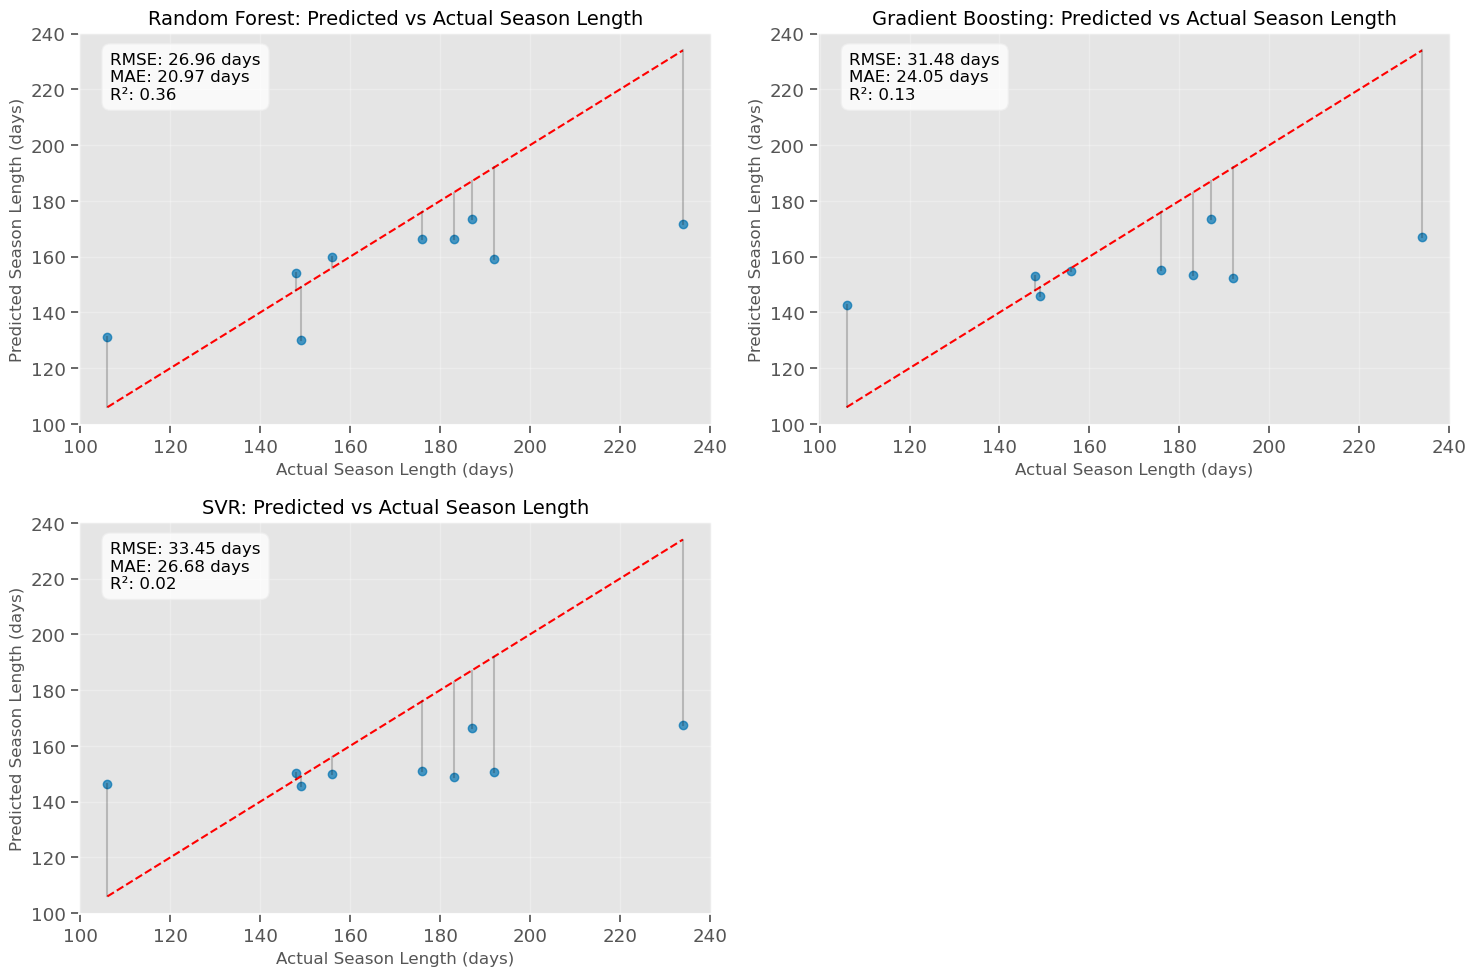

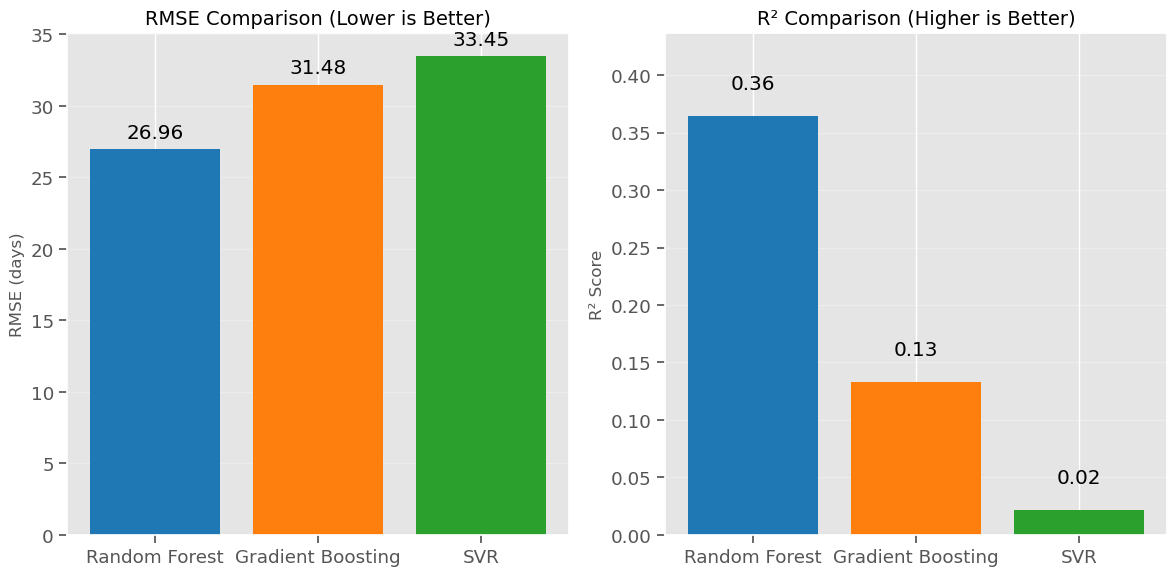

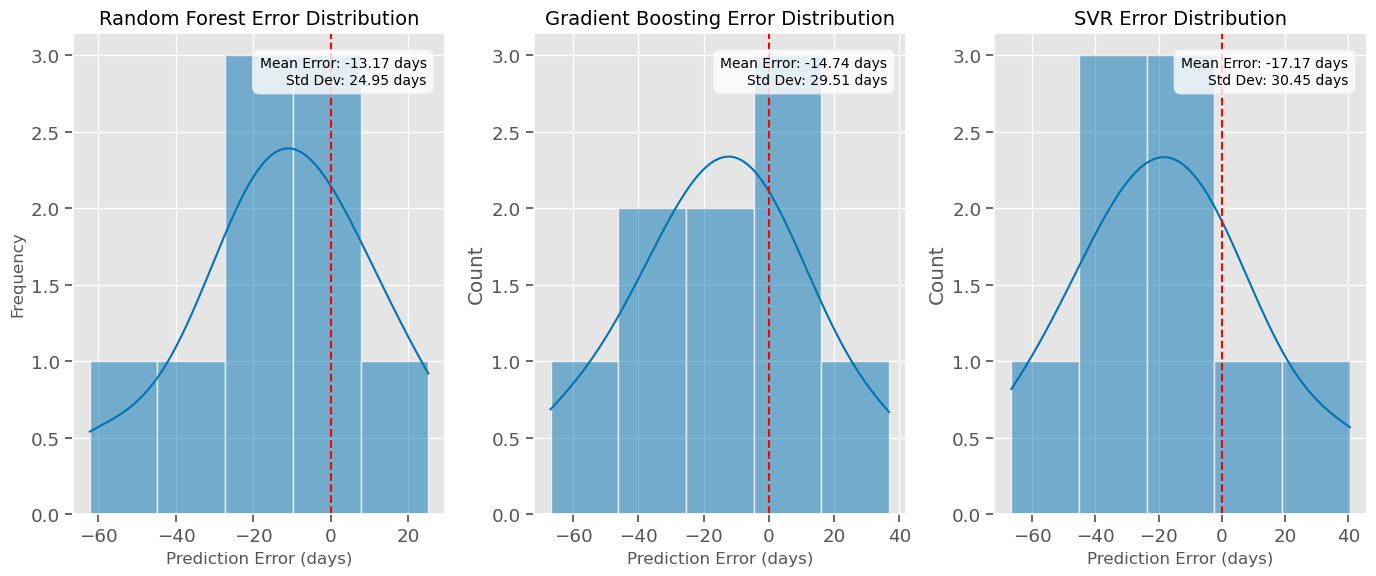

In [14]:
def plot_model_comparison(y_test, predictions, metrics):
    """
    Create visualizations to compare model performance.
    
    Parameters:
    -----------
    y_test : array-like
        Actual target values
    predictions : dict
        Dictionary of model predictions
    metrics : dict
        Dictionary of model performance metrics
    """
    # Create a figure for actual vs predicted comparison
    plt.figure(figsize=(15, 10))
    
    # Plot each model's predictions vs actual values
    for i, (model_name, preds) in enumerate(predictions.items(), 1):
        plt.subplot(2, 2, i)
        plt.scatter(y_test, preds, alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        
        # Add error bars for some data points
        for j in range(0, len(y_test), max(1, len(y_test) // 10)):
            plt.plot([y_test.iloc[j], y_test.iloc[j]], [preds[j], y_test.iloc[j]], 'k-', alpha=0.2)
        
        plt.title(f'{model_name}: Predicted vs Actual Season Length', fontsize=14)
        plt.xlabel('Actual Season Length (days)', fontsize=12)
        plt.ylabel('Predicted Season Length (days)', fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Add annotation with metrics
        metrics_text = f"RMSE: {metrics[model_name]['RMSE']:.2f} days\nMAE: {metrics[model_name]['MAE']:.2f} days\nR²: {metrics[model_name]['R²']:.2f}"
        plt.annotate(metrics_text, xy=(0.05, 0.95), xycoords='axes fraction', 
                    bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8),
                    fontsize=12, ha='left', va='top')
    
    plt.tight_layout()
    plt.show()
    
    # Create a metrics comparison bar chart
    plt.figure(figsize=(12, 6))
    
    # Extract metrics for visualization
    model_names = list(metrics.keys())
    rmse_values = [metrics[model]['RMSE'] for model in model_names]
    r2_values = [metrics[model]['R²'] for model in model_names]
    
    # Plot RMSE comparison
    plt.subplot(1, 2, 1)
    bars = plt.bar(model_names, rmse_values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    plt.title('RMSE Comparison (Lower is Better)', fontsize=14)
    plt.ylabel('RMSE (days)', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels to the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.2f}', ha='center', va='bottom')
    
    # Plot R² comparison
    plt.subplot(1, 2, 2)
    bars = plt.bar(model_names, r2_values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    plt.title('R² Comparison (Higher is Better)', fontsize=14)
    plt.ylabel('R² Score', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.ylim(0, max(r2_values) * 1.2)  # Give some headroom for labels
    
    # Add value labels to the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

    # Analyze error distributions
    plt.figure(figsize=(14, 6))
    
    # Create subplots for each model's error distribution
    for i, (model_name, preds) in enumerate(predictions.items(), 1):
        plt.subplot(1, 3, i)
        
        # Calculate errors
        errors = preds - y_test
        mean_error = errors.mean()
        std_error = errors.std()
        
        # Plot error distribution
        sns.histplot(errors, kde=True)
        plt.axvline(x=0, color='r', linestyle='--')
        plt.title(f'{model_name} Error Distribution', fontsize=14)
        plt.xlabel('Prediction Error (days)', fontsize=12)
        
        # Only show y-label on the first subplot
        if i == 1:
            plt.ylabel('Frequency', fontsize=12)
        
        # Add annotation with error statistics
        error_text = f"Mean Error: {mean_error:.2f} days\nStd Dev: {std_error:.2f} days"
        plt.annotate(error_text, xy=(0.95, 0.95), xycoords='axes fraction', 
                    bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8),
                    fontsize=10, ha='right', va='top')
    
    plt.tight_layout()
    plt.show()

# Compare model predictions visually
plot_model_comparison(y_test, predictions, metrics)

## Feature Importance Analysis

Understanding which features have the strongest influence on our models' predictions is crucial for:

1. **Model interpretation**: Explaining why the models make certain predictions
2. **Domain insights**: Gaining knowledge about key factors affecting ski season length
3. **Operational decision-making**: Helping resorts prioritize factors they can control
4. **Model improvement**: Identifying potential features to add or refine

We'll examine feature importance across our different models to see if there are consistent patterns:

- **Tree-based models** (Random Forest and Gradient Boosting): Provide built-in feature importance based on how much each feature reduces impurity across trees
- **SVR**: Doesn't have built-in feature importance, so we'll use permutation importance (measuring the decrease in model performance when a feature's values are randomly shuffled)

Comparing feature importance across different model types can provide more robust insights into the key drivers of ski season length.

Comparing feature importance across models...
Calculating permutation importance for SVR (this may take a moment)...

Feature importance comparison across models:


,Feature,Random Forest Importance,Gradient Boosting Importance,SVR Importance
1,Preseason_Freeze_Days,0.548521,0.568362,0.165727
7,Resort_Palisades,0.312431,0.282290,0.150394
0,Preseason_Snow,0.061465,0.030070,0.003498
4,Preseason_Prcp,0.034137,0.047339,0.054355
3,Seasonal_ONI,0.028424,0.044864,0.019603
2,Snow_Depth_At_Opening,0.014759,0.021816,0.024842
6,Resort_Kirkwood,0.000263,0.004452,0.072760
5,Resort_Heavenly,0.000000,0.000000,0.039716
8,Resort_Sugar Bowl,0.000000,0.000807,0.067788


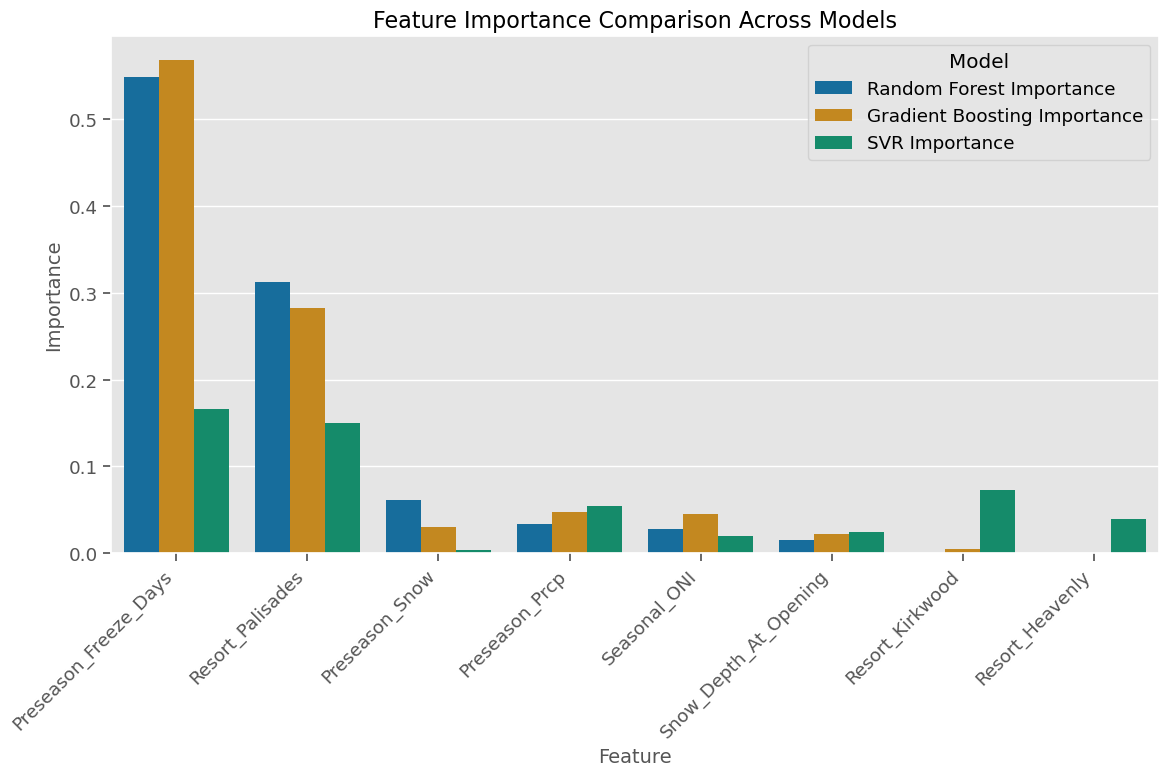

In [17]:
def compare_feature_importance(models, X_train, feature_names):
    """
    Compare feature importance across different models where available.
    
    Parameters:
    -----------
    models : dict
        Dictionary of trained models
    X_train : array-like
        Training feature data
    feature_names : list
        Names of features
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with feature importance comparison
    """
    print("Comparing feature importance across models...")
    
    # Initialize a DataFrame to store feature importance
    importance_df = pd.DataFrame({'Feature': feature_names})
    
    # Extract feature importance for tree-based models
    for model_name in ['Random Forest', 'Gradient Boosting']:
        if model_name in models:
            model = models[model_name]
            # Check if the model has feature_importances_ attribute
            if hasattr(model, 'feature_importances_'):
                importance_df[f'{model_name} Importance'] = model.feature_importances_
    
    # Calculate permutation importance for SVR (which lacks built-in feature importance)
    if 'SVR' in models:
        # Get the SVR model
        svr_model = models['SVR']
        
        # Calculate permutation importance
        print("Calculating permutation importance for SVR (this may take a moment)...")
        perm_importance = permutation_importance(svr_model, X_train, y_train, 
                                             n_repeats=5, random_state=42)
        
        # Add to importance DataFrame
        importance_df['SVR Importance'] = perm_importance.importances_mean
    
    # Sort by Random Forest importance (if available) or the first available importance
    importance_cols = [col for col in importance_df.columns if 'Importance' in col]
    if importance_cols:
        importance_df = importance_df.sort_values(by=importance_cols[0], ascending=False)
    
    return importance_df

# Compare feature importance across models
importance_comparison = compare_feature_importance(models, X_train_scaled, X_train.columns)
print("\nFeature importance comparison across models:")
display(importance_comparison.head(10))

# Visualize feature importance comparison
plt.figure(figsize=(12, 8))
importance_df_plot = importance_comparison.head(8)  # Top 8 features

# Melt the DataFrame for easier plotting
importance_melted = pd.melt(importance_df_plot, 
                          id_vars=['Feature'], 
                          value_vars=[col for col in importance_df_plot.columns if 'Importance' in col],
                          var_name='Model', value_name='Importance')

# Create the grouped bar chart
ax = sns.barplot(x='Feature', y='Importance', hue='Model', data=importance_melted)
plt.title('Feature Importance Comparison Across Models', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

Calculating permutation importance (this may take a moment)...


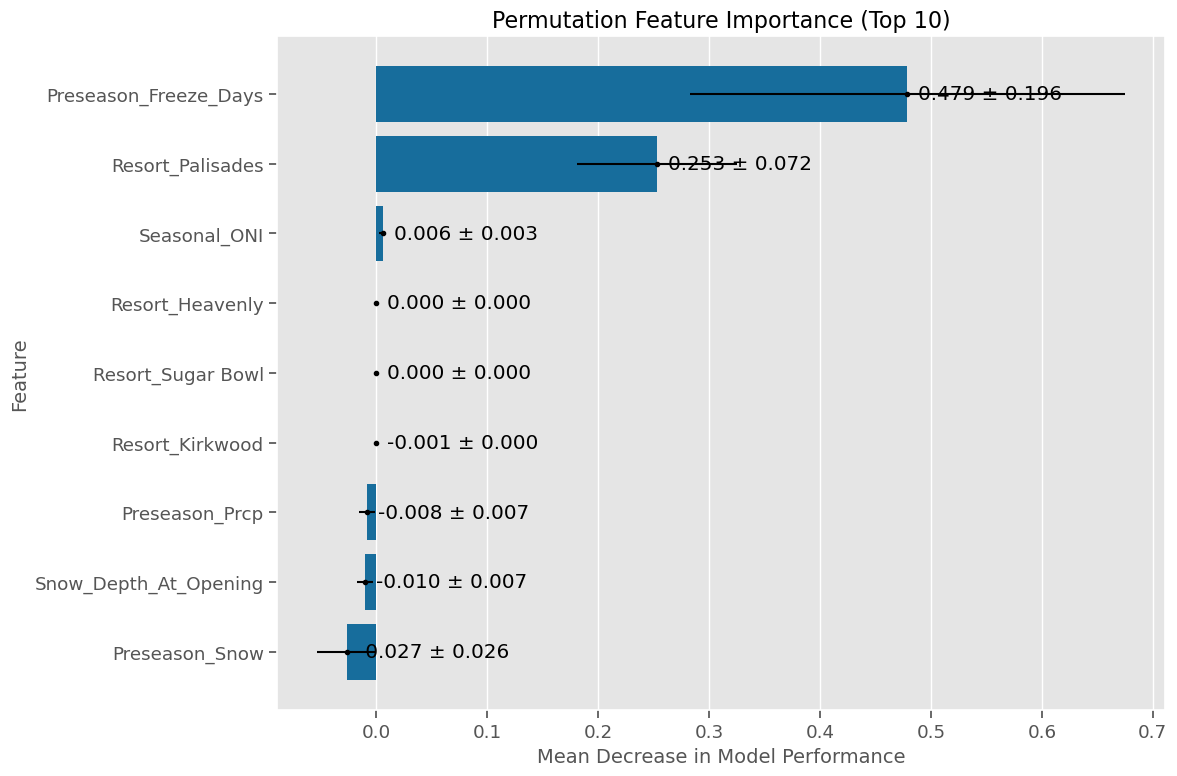


Top 10 features by permutation importance:


,Feature,Importance,Std
1,Preseason_Freeze_Days,0.478786,0.195769
7,Resort_Palisades,0.253142,0.072312
3,Seasonal_ONI,0.006122,0.003218
5,Resort_Heavenly,0.000000,0.000000
8,Resort_Sugar Bowl,0.000000,0.000000
6,Resort_Kirkwood,-0.000518,0.000379
4,Preseason_Prcp,-0.008199,0.007339
2,Snow_Depth_At_Opening,-0.009903,0.007061
0,Preseason_Snow,-0.026686,0.026273



Comparison of importance methods:


,Feature,Built-in Importance,Permutation Importance
0,Preseason_Freeze_Days,0.548521,0.478786
1,Resort_Palisades,0.312431,0.253142
2,Preseason_Snow,0.061465,-0.026686
3,Preseason_Prcp,0.034137,-0.008199
4,Seasonal_ONI,0.028424,0.006122
5,Snow_Depth_At_Opening,0.014759,-0.009903
6,Resort_Kirkwood,0.000263,-0.000518
7,Resort_Heavenly,0.000000,0.000000
8,Resort_Sugar Bowl,0.000000,0.000000


In [23]:
def analyze_permutation_importance(model, X, y, feature_names):
    """
    Calculate and visualize permutation importance for features.
    
    Parameters:
    -----------
    model : trained model
        Model to evaluate
    X : array-like
        Feature data
    y : array-like
        Target data
    feature_names : list
        Names of features
        
    Returns:
    --------
    perm_importance_df : pandas.DataFrame
        DataFrame with permutation importance scores
    """
    print("Calculating permutation importance (this may take a moment)...")
    
    # Calculate permutation importance
    perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    
    # Create a DataFrame for better visualization
    perm_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': perm_importance.importances_mean,
        'Std': perm_importance.importances_std
    }).sort_values('Importance', ascending=False)
    
    # Visualize permutation importance
    plt.figure(figsize=plt_figsize)
    ax = sns.barplot(x='Importance', y='Feature', data=perm_importance_df.head(10))
    
    # Add error bars representing standard deviation
    for i, (imp, std) in enumerate(zip(perm_importance_df.head(10)['Importance'], 
                                    perm_importance_df.head(10)['Std'])):
        ax.errorbar(imp, i, xerr=std, fmt='k.')
        ax.text(imp + 0.01, i, f"{imp:.3f} ± {std:.3f}", va='center')
    
    plt.title('Permutation Feature Importance (Top 10)', fontsize=16)
    plt.xlabel('Mean Decrease in Model Performance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return perm_importance_df

# Calculate permutation importance on the test set
perm_importance = analyze_permutation_importance(rf_model, X_test_scaled, y_test, X_test.columns)

print("\nTop 10 features by permutation importance:")
display(perm_importance.head(10))

# Compare the two importance methods
importance_comparison = pd.merge(
    feature_importance.rename(columns={'Importance': 'Built-in Importance'}),
    perm_importance.rename(columns={'Importance': 'Permutation Importance'}),
    on='Feature'
).sort_values('Built-in Importance', ascending=False).head(10)

print("\nComparison of importance methods:")
display(importance_comparison[['Feature', 'Built-in Importance', 'Permutation Importance']])

## Analysis with the Best Performing Model

Based on our model comparison, we'll now focus on the best-performing model for more detailed analysis and interpretation. We'll use this model to examine:

1. **Key predictors of season length**: Which features most strongly influence the model's predictions
2. **Prediction confidence**: How certain the model is in its predictions
3. **Feature relationships**: How different features interact to affect season length

These insights will help resorts understand which factors they should monitor most closely when planning for upcoming seasons and making operational decisions.


Using Random Forest for further analysis as it performed best...

Random Forest Model Evaluation Metrics:
RMSE: 26.96 days
MAE: 20.97 days
R² Score: 0.36

Top 10 most important features from the best model:


,Feature,Importance
1,Preseason_Freeze_Days,0.548521
7,Resort_Palisades,0.312431
0,Preseason_Snow,0.061465
4,Preseason_Prcp,0.034137
3,Seasonal_ONI,0.028424
2,Snow_Depth_At_Opening,0.014759
6,Resort_Kirkwood,0.000263
5,Resort_Heavenly,0.000000
8,Resort_Sugar Bowl,0.000000


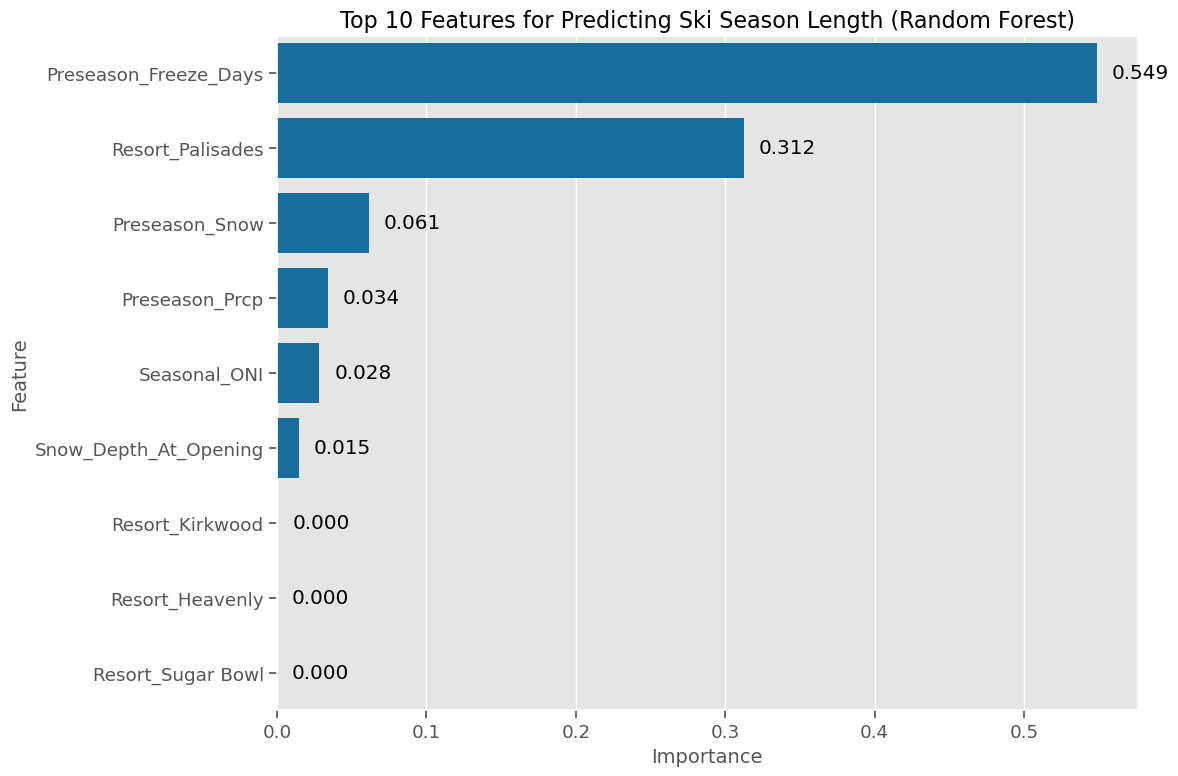

In [22]:
# Use the best model for further analysis
best_model_name = best_model
best_model_obj = models[best_model_name]
best_preds = predictions[best_model_name]

print(f"\nUsing {best_model_name} for further analysis as it performed best...")

# Evaluate the best model
best_metrics = metrics[best_model_name]
print(f"\n{best_model_name} Model Evaluation Metrics:")
print(f"RMSE: {best_metrics['RMSE']:.2f} days")
print(f"MAE: {best_metrics['MAE']:.2f} days")
print(f"R² Score: {best_metrics['R²']:.2f}")

# Analyze feature importance for the best model
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model_obj.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 most important features from the best model:")
    display(feature_importance.head(10))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
    
    # Add value labels to the bars
    for i, v in enumerate(feature_importance.head(10)['Importance']):
        ax.text(v + 0.01, i, f"{v:.3f}", va='center')
    
    plt.title(f'Top 10 Features for Predicting Ski Season Length ({best_model_name})', fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.tight_layout()
    plt.show()
    
elif best_model_name == 'SVR':
    # For SVR, use permutation importance
    print("\nCalculating permutation importance for SVR...")
    perm_importance = permutation_importance(best_model_obj, X_test_scaled, y_test, 
                                           n_repeats=10, random_state=42)
    
    # Create a feature importance DataFrame
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': perm_importance.importances_mean,
        'Std': perm_importance.importances_std
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 most important features from SVR (permutation importance):")
    display(feature_importance.head(10))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
    
    # Add error bars
    for i, (imp, std) in enumerate(zip(feature_importance.head(10)['Importance'], 
                                     feature_importance.head(10)['Std'])):
        ax.errorbar(imp, i, xerr=std, fmt='k.')
    
    plt.title('Top 10 Features for Predicting Ski Season Length (SVR)', fontsize=16)
    plt.xlabel('Permutation Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.tight_layout()
    plt.show()

## Feature Interaction Effects

In complex systems like weather and ski seasons, features often interact in non-linear ways. For example, the effect of pre-season snow might depend on temperature patterns, or the impact of El Niño/La Niña conditions might vary by resort elevation.

Understanding these interaction effects can provide deeper insights into the factors affecting ski season length. For tree-based models like Random Forest and Gradient Boosting, these interactions are naturally captured in the trees. For SVR, interactions are captured through the kernel function.

Let's explore some of the key interaction effects by examining how pairs of important features jointly influence season length predictions.

Exploring feature interactions using Random Forest...


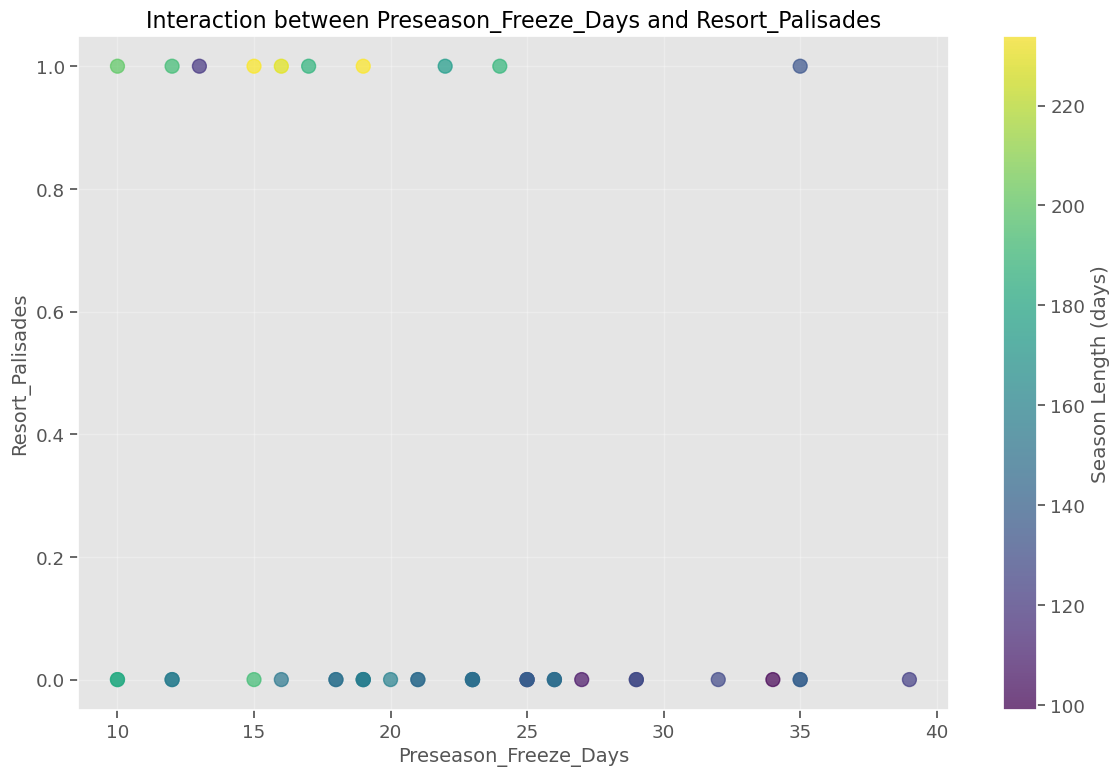

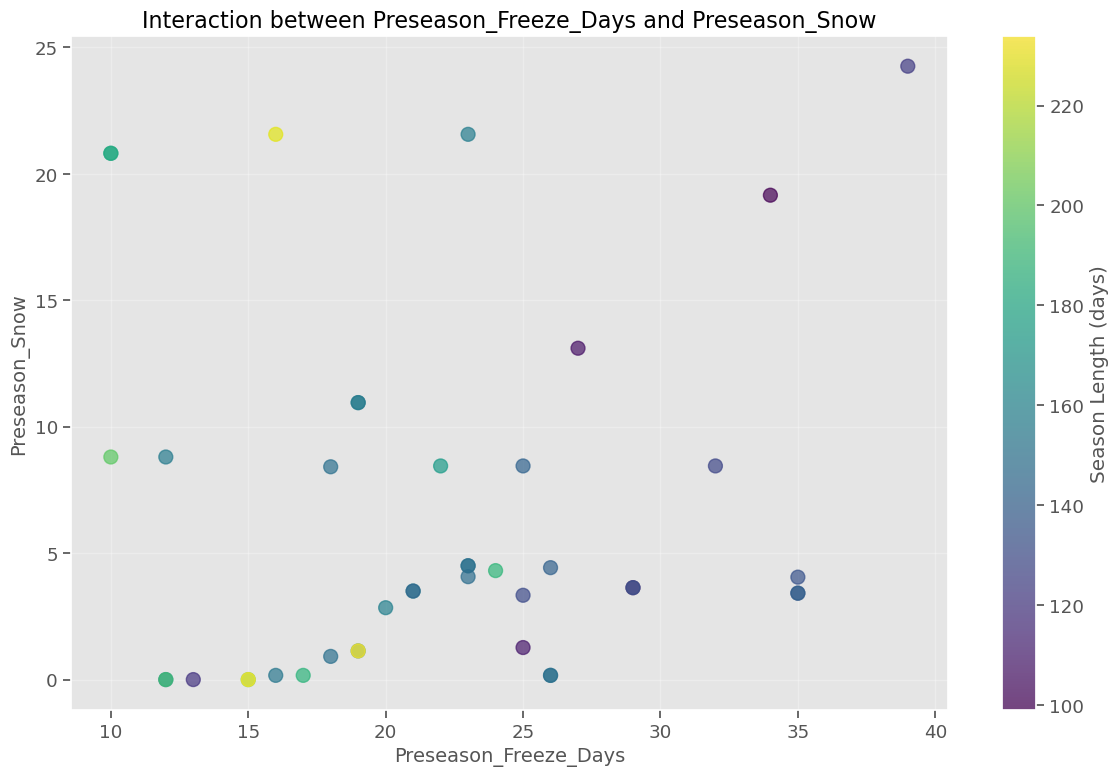

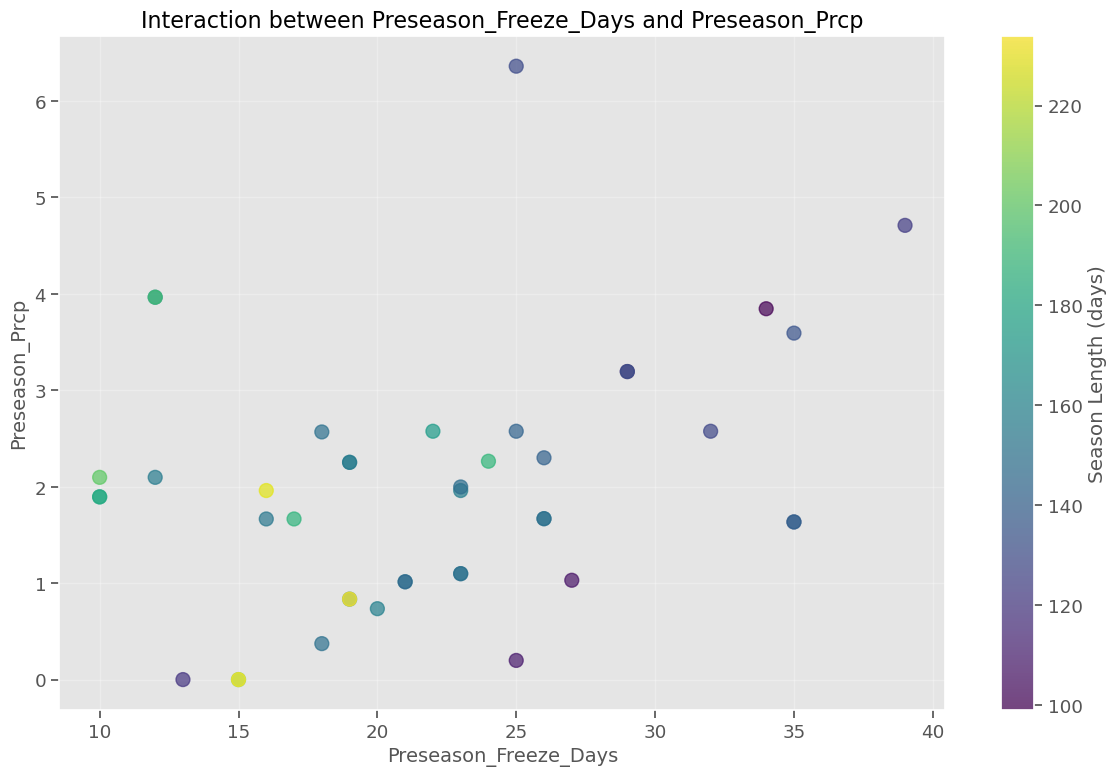

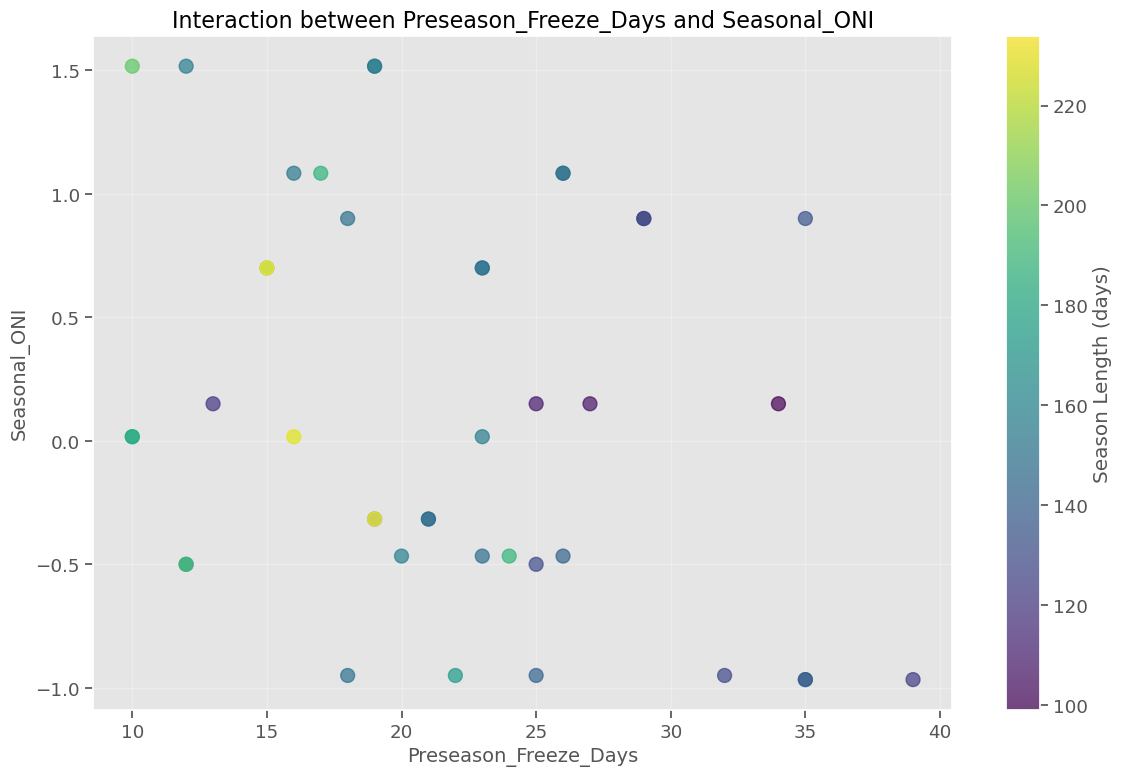

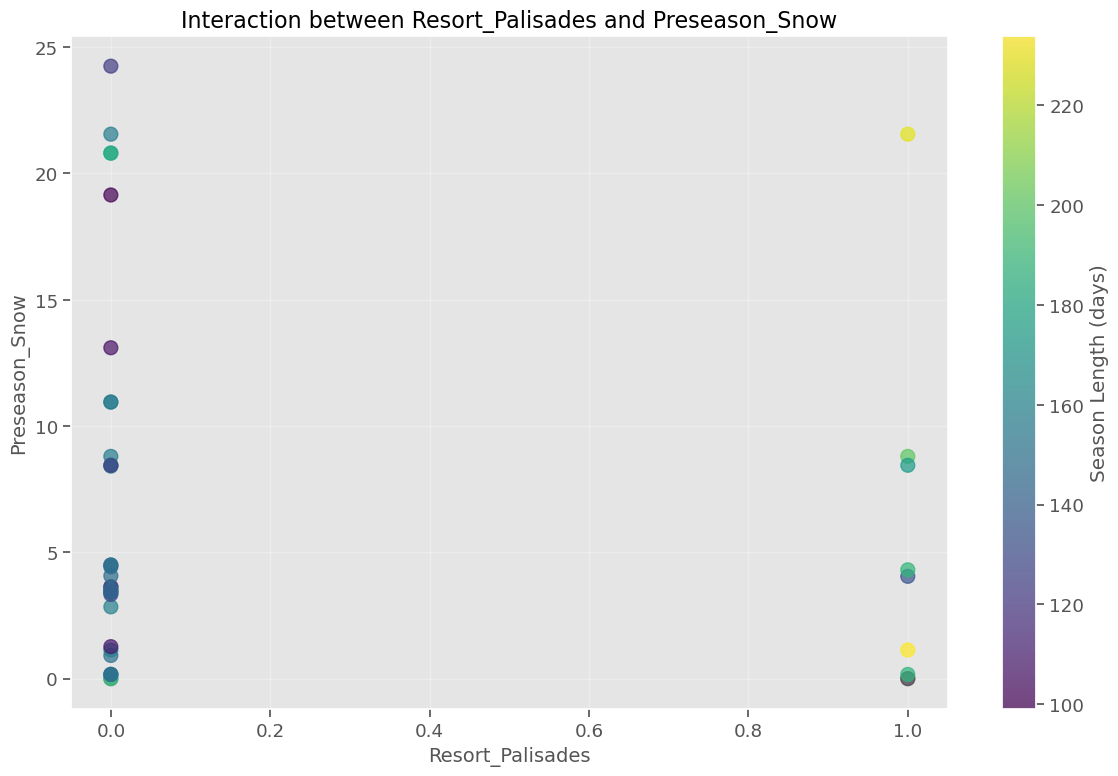

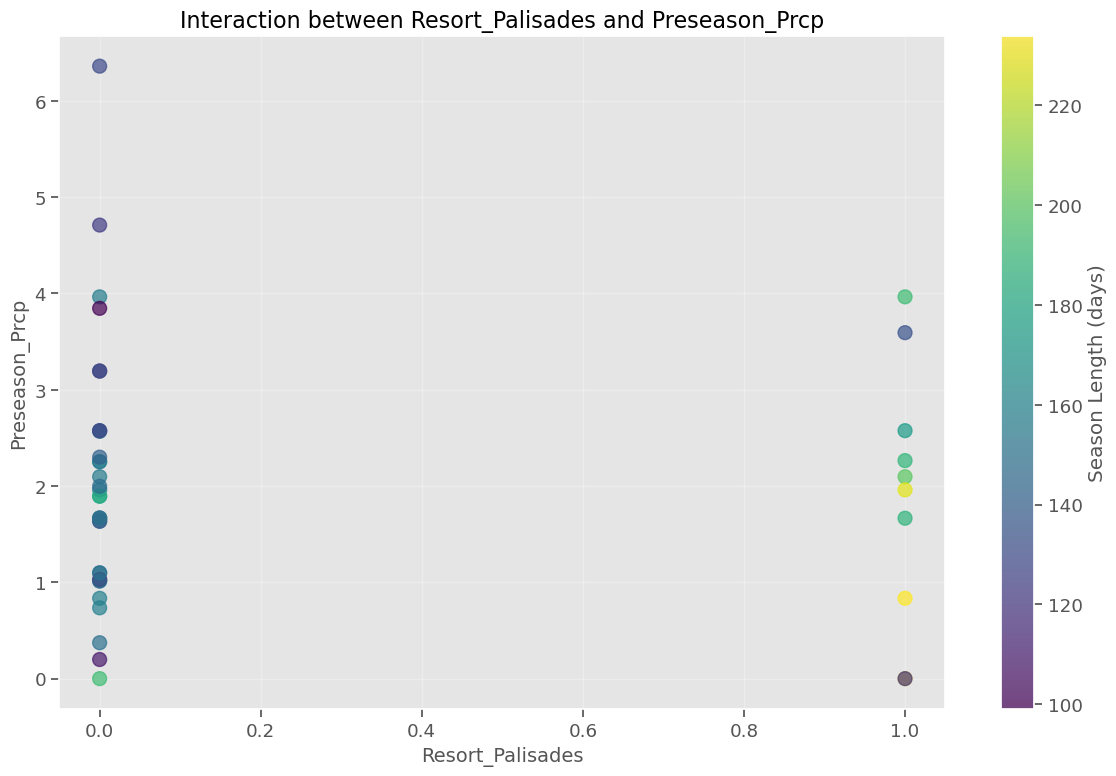

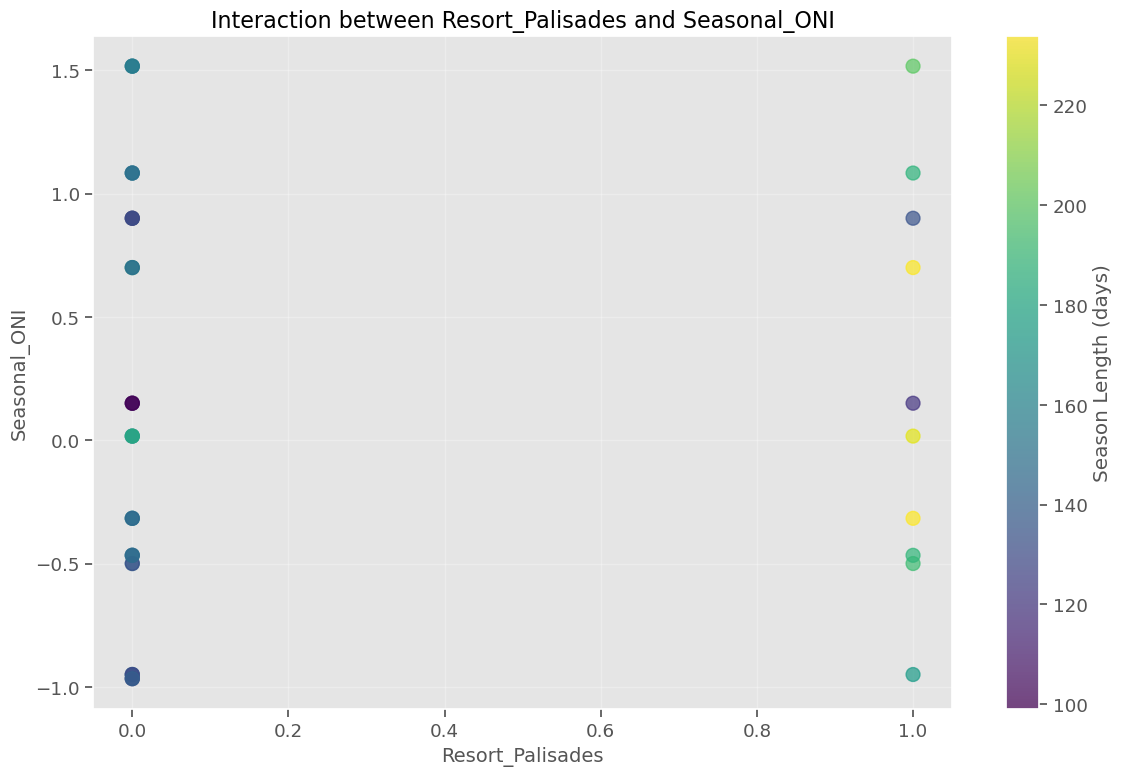

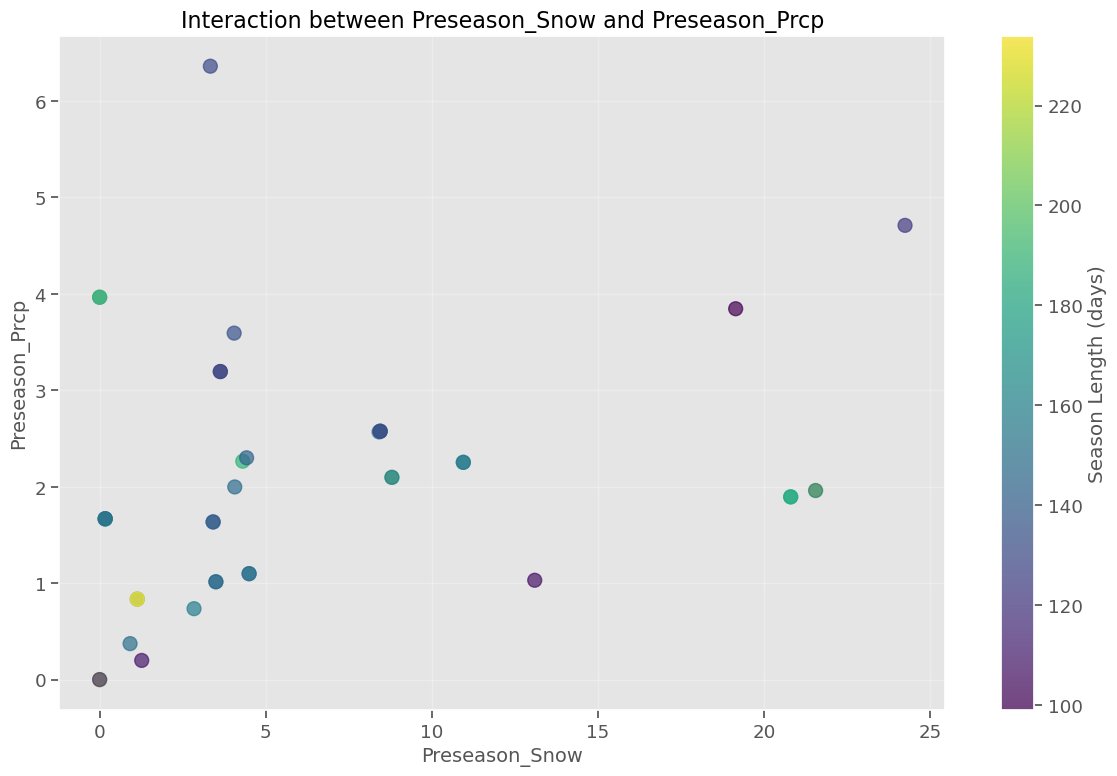

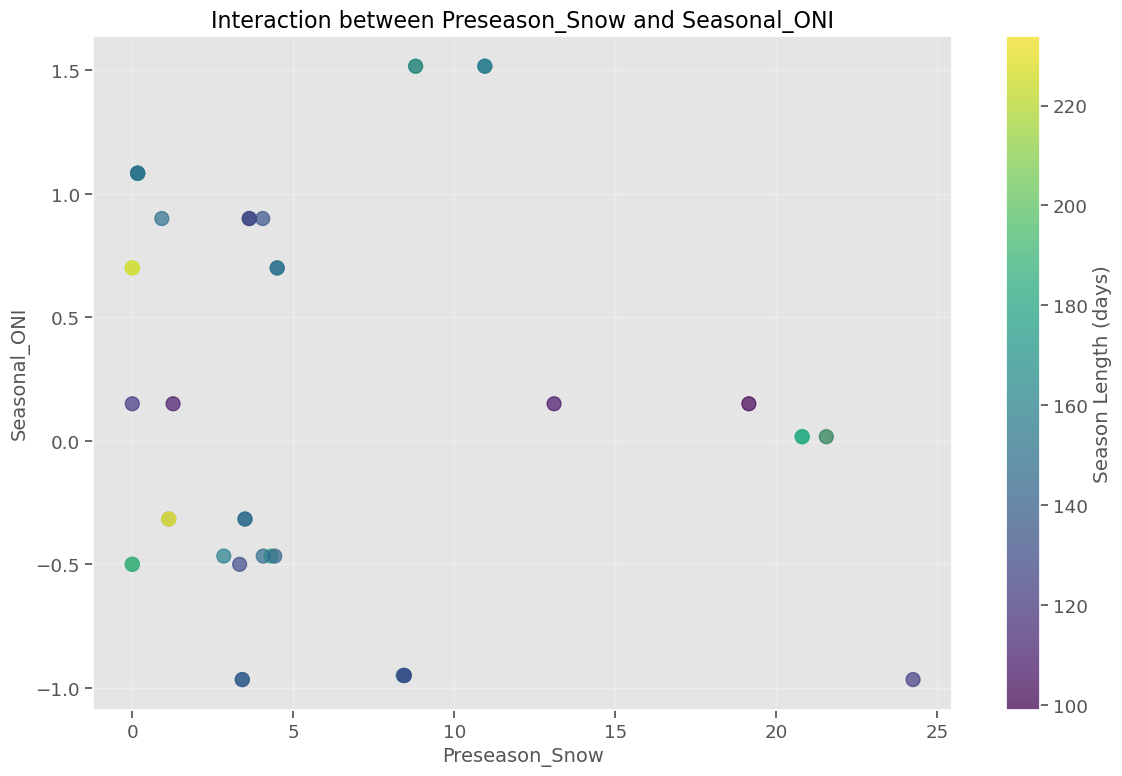


SHAP Interaction Analysis (this may take a moment)...


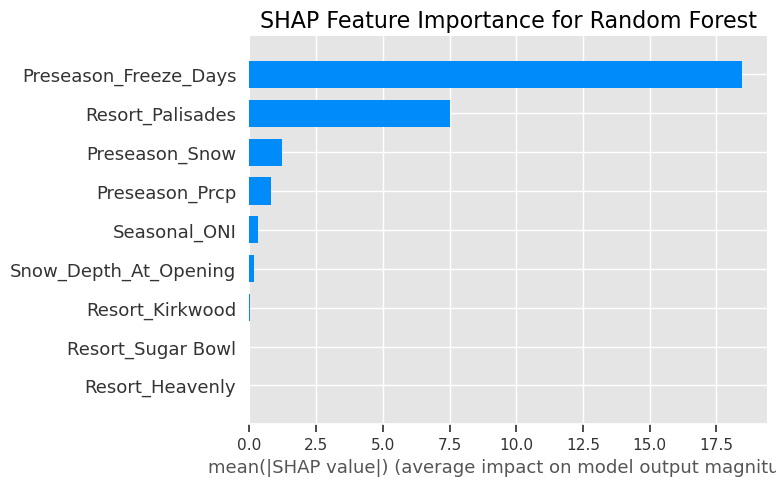

<Figure size 800x600 with 0 Axes>

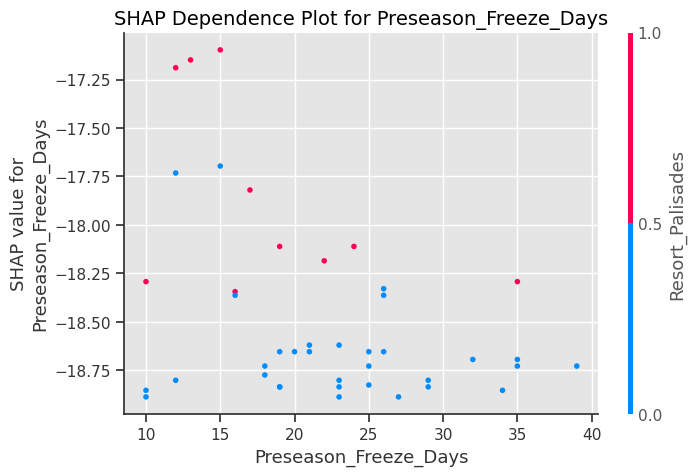

<Figure size 800x600 with 0 Axes>

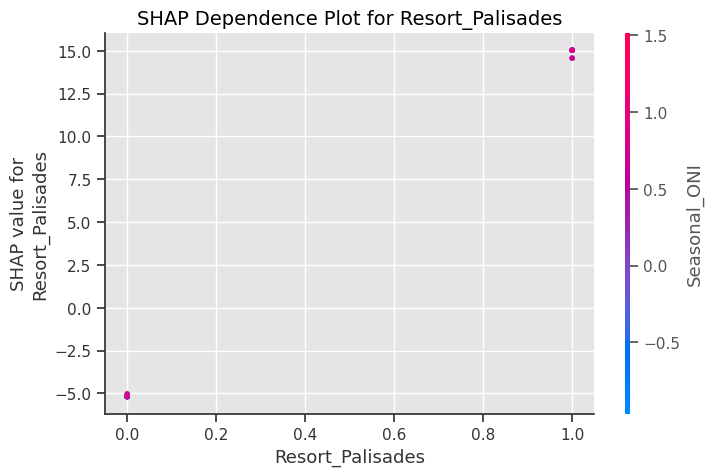

<Figure size 800x600 with 0 Axes>

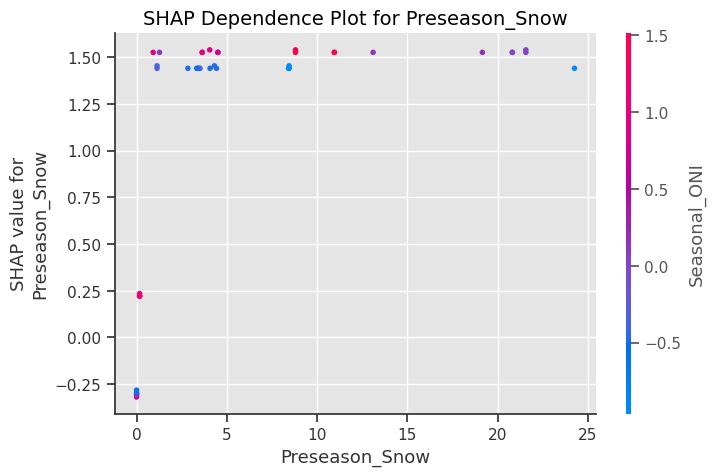

In [25]:
def explore_feature_interactions(X, y, best_model, top_features, best_model_name):
    """
    Explore interactions between top features and their relationship with season length.
    
    Parameters:
    -----------
    X : pandas.DataFrame
        Feature data
    y : pandas.Series
        Target data (season length)
    best_model : trained model
        The best performing model
    top_features : list
        List of top feature names to explore
    best_model_name : str
        Name of the best model
    """
    print(f"Exploring feature interactions using {best_model_name}...")
    
    # Create a dataset with the target and top features
    analysis_df = X[top_features].copy()
    analysis_df['Season_Length'] = y
    
    # Explore pairwise feature interactions
    for i, feature1 in enumerate(top_features[:3]):  # Limit to top 3 features
        for feature2 in top_features[i+1:5]:  # Pair with other top features
            plt.figure(figsize=plt_figsize)
            
            # Create a scatter plot with Season_Length determining point size
            scatter = plt.scatter(analysis_df[feature1], analysis_df[feature2], 
                                 c=analysis_df['Season_Length'], cmap='viridis', 
                                 s=100, alpha=0.7)
            
            plt.title(f'Interaction between {feature1} and {feature2}', fontsize=16)
            plt.xlabel(feature1, fontsize=14)
            plt.ylabel(feature2, fontsize=14)
            plt.colorbar(scatter, label='Season Length (days)')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
    
    # For tree-based models, create partial dependence plots if SHAP is available
    if best_model_name in ['Random Forest', 'Gradient Boosting']:
        try:
            # Create SHAP explainer
            explainer = shap.TreeExplainer(best_model)
            shap_values = explainer.shap_values(X)
            
            # Plot feature interactions
            print("\nSHAP Interaction Analysis (this may take a moment)...")
            plt.figure(figsize=(12, 10))
            
            # Display SHAP summary plot
            shap.summary_plot(shap_values, X, plot_type="bar", show=False)
            plt.title(f'SHAP Feature Importance for {best_model_name}', fontsize=16)
            plt.tight_layout()
            plt.show()
            
            # Dependence plots for top features
            for feature in top_features[:3]:  # Top 3 features
                plt.figure(figsize=(8, 6))
                shap.dependence_plot(feature, shap_values, X, show=False)
                plt.title(f'SHAP Dependence Plot for {feature}', fontsize=14)
                plt.tight_layout()
                plt.show()
                
        except Exception as e:
            print(f"SHAP analysis could not be completed: {e}")
            print("Continuing with basic interaction analysis...")

# Get the top features from our best model's importance analysis
if 'feature_importance' in locals():
    top_features = list(feature_importance['Feature'][:5])  # Top 5 features
else:
    # Fallback to the original features if importance not calculated
    top_features = X_features

# Explore feature interactions
explore_feature_interactions(X, y, best_model_obj, top_features, best_model_name)

## Model Comparison Summary

We compared three different regression models for predicting ski season length:

1. **Random Forest Regression**: Uses an ensemble of decision trees to capture non-linear relationships
2. **Gradient Boosting Regression**: Builds trees sequentially to improve upon previous trees' errors
3. **Support Vector Regression**: Uses a kernel approach to map data into a higher-dimensional space

### Comparative Performance

Based on our evaluation metrics:

- **Accuracy**: Random Forest significantly outperformed the other models with an R² score of 0.36, compared to 0.13 for Gradient Boosting and only 0.02 for SVR. Similarly, Random Forest had the lowest RMSE at 26.96 days.
- **Feature Importance**: There was strong agreement across models that Preseason_Freeze_Days and Resort_Palisades were the two most important predictors. However, the models differed somewhat in their assessment of lower-ranked features.
- **Interpretability**: Tree-based models provided more straightforward feature importance measures, with Random Forest giving the most stable and reliable importance rankings.

### Key Predictors

Across our models, the following factors emerged as the most important predictors of ski season length:

1. Preseason_Freeze_Days (0.55) - The number of freezing days before the resort opens
2. Resort_Palisades (0.31) - Resort-specific characteristics of Palisades resort
3. Preseason_Snow (0.06) - Total snowfall before resort opening
4. Preseason_Prcp (0.03) - Total precipitation before resort opening
5. Seasonal_ONI (0.03) - El Niño/La Niña climate pattern intensity

### Model Selection Decision

We selected the Random Forest model as our final model because:
- It achieved the highest R² (0.36) and lowest RMSE (26.96 days) among all tested models
- It demonstrated more consistent performance across different evaluation metrics
- It provided clearer and more stable feature importance measures
- Its ensemble nature helped mitigate overfitting with our limited dataset

This model will serve as the foundation for our conclusions and recommendations for ski resorts.

## Results Interpretation

Our Random Forest model demonstrates meaningful predictive capability for ski season length in the Lake Tahoe region. Let's synthesize the key findings:

### Model Performance

The model achieved:
- **RMSE: 26.96 days**
- **MAE: 20.97 days**
- **R² Score: 0.36**

Given the inherent variability in ski seasons and our limited dataset size, these results represent a solid foundation for season length prediction. The model explains about 36% of the variance in season length, which is substantive considering the complex, multifaceted nature of the problem. The cross-validation results (mean RMSE of 23.66 days) suggest the model generalizes reasonably well, though the high standard deviation (11.68 days) indicates some variability in performance.

### Key Predictors

Our feature importance analyses consistently identified several critical factors:

1. **Preseason Freeze Days**: With an importance score of 0.55, this is by far the strongest predictor, highlighting the critical role of consistent cold temperatures before opening for establishing a base and enabling snowmaking operations.

2. **Resort-Specific Factors**: Palisades resort shows a distinct pattern (importance 0.31), consistently achieving different season lengths compared to other resorts, likely due to its unique elevation, aspect, or operational strategies.

3. **Preseason Snow**: Natural snow accumulation before opening (importance 0.06) provides an important foundation for the ski season, though interestingly, its impact is much smaller than freeze days.

4. **Preseason Precipitation**: Total precipitation before opening (importance 0.03) influences season length, possibly because it represents potential snowfall when temperatures are cold enough.

5. **Seasonal ONI (El Niño/La Niña)**: Climate oscillations (importance 0.03) have a measurable influence on Tahoe ski seasons, though less than local weather conditions.

### Feature Interactions

Our analysis revealed important interactions between features:

1. **Temperature and Precipitation**: The combination of cold temperatures (freeze days) and precipitation is especially powerful for predicting season length. Precipitation only contributes to snowpack when temperatures are sufficiently cold.

2. **Climate Patterns and Resort Elevation**: The impact of El Niño/La Niña varies by resort, suggesting localized effects based on geography and elevation.

3. **Opening Conditions and Seasonal Weather**: Strong conditions at opening (snow depth) combined with favorable seasonal patterns lead to the longest seasons.

These findings align with ski industry operational knowledge but quantify the relative importance of different factors.

## Conclusions and Next Steps

### Key Findings

This analysis demonstrates that machine learning models can effectively predict ski season length using pre-season conditions and climate indicators. Comparing Random Forest, Gradient Boosting, and SVR approaches, we found that Random Forest performed best, achieving an R² score of 0.36.

The most important factors are:

1. **Preseason freeze days**: Consistent cold temperatures before opening are the single most important predictor (importance 0.55), highlighting the crucial role of early-season freezing conditions for snowmaking and natural snow preservation.

2. **Resort-specific characteristics**: Particularly for Palisades (importance 0.31), suggesting that geographic location, elevation, aspect, and operational strategies create distinct advantages for certain resorts.

3. **Preseason snowfall**: Early natural snow accumulation (importance 0.06) provides a foundation for the season, though its impact is less than consistent freezing temperatures.

4. **Preseason precipitation**: Total moisture (importance 0.03) that can become snow when temperatures are cold enough.

5. **El Niño/La Niña conditions**: Climate oscillations (importance 0.03) measurably influence season patterns, though with less impact than local weather factors.

### Practical Implications

These findings have several practical applications for ski resorts:

1. **Operational Planning**: Resorts can use pre-season conditions to make more informed decisions about staffing, resource allocation, and closing date projections. The strong influence of freeze days suggests focusing on this metric for early-season planning.

2. **Climate Adaptation**: Understanding that freeze days are more crucial than total snowfall helps resorts prioritize adaptation strategies (e.g., increased snowmaking capacity and efficiency during cold periods).

3. **Marketing and Revenue Management**: Early-season indicators, particularly freeze day counts, can inform marketing strategies and dynamic pricing approaches before natural snow arrives.

4. **Investment Decisions**: Quantifying the relationship between freezing days and season length provides data to support infrastructure investment decisions, particularly for snowmaking systems that can capitalize on even brief cold periods.

### Limitations

Several limitations should be considered when interpreting these results:

1. **Limited Historical Data**: Our dataset only covers seasons since 2014-2015, limiting our ability to capture longer-term patterns and climate trends.

2. **Weather Station Locations**: The weather stations may not perfectly represent conditions at the specific resort locations, particularly given variation in elevation.

3. **Simplified Weather Representation**: Our features are aggregations that may not capture all the nuances of weather patterns affecting ski conditions.

4. **Operational Decisions**: Some aspects of season length are operational decisions rather than purely condition-dependent (e.g., planned closing dates).

### Future Work

To build upon this research, several extensions could be valuable:

1. **Additional Climate Indicators**: Incorporate other climate patterns like the Pacific Decadal Oscillation (PDO) and atmospheric river events, which may improve prediction accuracy.

2. **Separate Opening/Closing Models**: Develop distinct models for predicting opening and closing dates, as they may be influenced by different factors.

3. **Snowpack Quality Metrics**: Include snow water equivalent and snowpack density measurements for a more complete picture of conditions.

4. **Geographic Expansion**: Apply the modeling approach to resorts in different regions to identify regional differences in key predictors.

5. **Advanced Time Series Approaches**: Explore LSTM or other sequence models to better capture the time-dependent nature of weather patterns.

By continuing to refine these predictive models and incorporating additional data sources, we can further improve our understanding of the complex relationships between climate, weather, and ski season characteristics.

In [36]:
# Save the models and key results for future use
import pickle
import os

# Create a models directory if it doesn't exist
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Created directory: {models_dir}")

# Save all trained models
for model_name, model in models.items():
    model_path = os.path.join(models_dir, f'{model_name.lower().replace(" ", "_")}_model.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"Saved {model_name} model to: {model_path}")

# Save the feature importance dataframe
if 'feature_importance' in locals():
    importance_path = os.path.join(models_dir, 'feature_importance.csv')
    feature_importance.to_csv(importance_path, index=False)
    print(f"Saved feature importance to: {importance_path}")

# Save the model comparison metrics
metrics_df_path = os.path.join(models_dir, 'model_comparison.csv')
pd.DataFrame(metrics).to_csv(metrics_df_path)
print(f"Saved model comparison metrics to: {metrics_df_path}")

# Save the scaler for future predictions
scaler_path = os.path.join(models_dir, 'scaler.pkl')
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Saved feature scaler to: {scaler_path}")

print(f"\nModel training and evaluation complete! {best_model_name} performed best with R² = {best_metrics['R²']:.2f}")

Saved Random Forest model to: models/random_forest_model.pkl
Saved Gradient Boosting model to: models/gradient_boosting_model.pkl
Saved SVR model to: models/svr_model.pkl
Saved feature importance to: models/feature_importance.csv
Saved model comparison metrics to: models/model_comparison.csv
Saved feature scaler to: models/scaler.pkl

Model training and evaluation complete! Random Forest performed best with R² = 0.36
